# Stroke analysis script

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as st
import os
import pickle

parcellation = 'Sch240'
n_connectomes = '20'
behaviour_list = ['APM','NART_IQ','Q1_TotalWords','Q6_TotalCorrect','CoC_abs_rev']
normalise_behav = True
reverse_behav = True
regress_size = False
CCApermutations = 1000
MCA_components = 5
CCA_components = 5
outdir = '/Users/luke/Documents/Projects/StrokeNet/Docs/Figures/2020/'

# Load data

In [3]:
behav_df, CM, NIFTI = st.load_data(parcellation=parcellation,
                         n_connectomes=n_connectomes,
                         behaviour_list=behaviour_list)

MNIcoords, networks, network_labels = st.get_atlas_info(parcellation=parcellation)

136it [00:06, 20.62it/s]
80it [00:15,  5.19it/s]


### Save data for online repository

In [4]:
import nibabel as nib
import tqdm
import h5py
# save behaviour (remove idenitifiers)
out_df = behav_df[['Age','APM','NART_IQ','Q1_TotalWords','Q6_TotalCorrect','CoC_abs_rev']]
out_df.rename(columns={'Q1_TotalWords': 'spontaneous_speech', 'Q6_TotalCorrect': 'verbal fluency'}, inplace=True)
out_df.to_csv('/Users/luke/Documents/Projects/StrokeNet/Docs/Raw_data_online/behavioural_data.csv')
              
# save lesion maps as single compressed file
dir_nifti = '/Users/luke/Documents/Projects/StrokeNet/Data/lesionMaps/2_Nii/'
# load nifti files (after dropping other subjects)
nifti_data = np.zeros((181,217,181,len(behav_df)))
for i, subj in enumerate(behav_df['ID']):
    file = dir_nifti+subj+'.nii'
    nifti_data[:,:,:,i] = nib.load(file).get_data()
    affine = nib.load(file).get_affine()
img = nib.Nifti1Image(nifti_data, affine)
nib.save(img,'/Users/luke/Documents/Projects/StrokeNet/Docs/Raw_data_online/lesion_maps.nii.gz')

# save connectivity matrices as a h5py file
h5f = h5py.File('/Users/luke/Documents/Projects/StrokeNet/Docs/Raw_data_online/connectivity_matrices.h5','a')
for cm_type in CM.keys():
    try:
        h5f.create_dataset(parcellation+'_'+cm_type+'/',data=CM[cm_type])
    except:
        del h5f[parcellation+'_'+cm_type+'/']
        h5f.create_dataset(parcellation+'_'+cm_type+'/',data=CM[cm_type])
h5f.close()

### Behaviour plot

[[ 1.          0.23865773  0.41317585  0.20543987  0.34704538]
 [ 0.23865773  1.          0.45512201  0.33680595 -0.00802103]
 [ 0.41317585  0.45512201  1.          0.38843011  0.23956493]
 [ 0.20543987  0.33680595  0.38843011  1.          0.05731903]
 [ 0.34704538 -0.00802103  0.23956493  0.05731903  1.        ]]


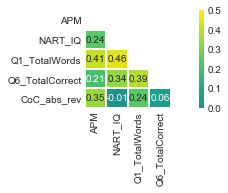

In [5]:
labels = behaviour_list
data = behav_df[behaviour_list].values
st.plotting_tools.behav_heatmap(data,labels,title=outdir+'behav_corr_plot.svg')

In [6]:
# do fdr correction on behaviour
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
r,p = spearmanr(data)
# rank correlation between behavioural variables
corr = spearmanr(data)[0]

mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask,k=-1)] = True
p_vals = p[mask>0]
print(p_vals)
p_adj = multipletests(p_vals,method='fdr_bh')[1]
print(p_adj<0.05)

[3.30122571e-02 1.39489495e-04 2.21992794e-05 6.75280519e-02
 2.25168451e-03 3.70243422e-04 1.61130770e-03 9.43704733e-01
 3.23319621e-02 6.13542146e-01]
[ True  True  True False  True  True  True False  True False]


### Lesion distribution plots

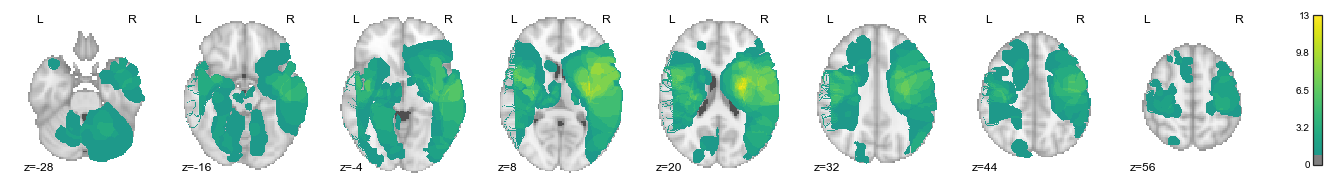

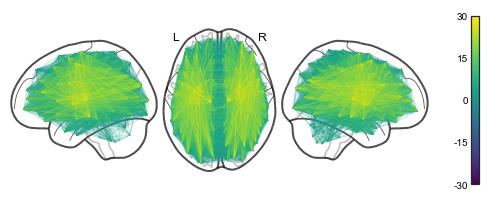

In [7]:
st.plotting_tools.lesion_dist_nii(NIFTI,title=outdir+'lesion_dist.svg') # consider loading in the original nifti rather than resized for better image
st.plotting_tools.lesion_dist_cm(CM['Diff'],MNIcoords=MNIcoords,vmin=-30,title=outdir+'lesion_conn_dist.jpeg')

### Demographics

In [8]:
do_demographics=0
if do_demographics:
    for meas in ['Age','Education','Chronicity','NART_IQ','APM','Q1_TotalWords','Q6_TotalCorrect','CoC_abs_rev']:
        print(meas)
        print('\tMean =',np.round(np.mean(behav_df[meas]),2))
        #print('\tMedian =',np.round(np.median(behav_df[meas]),2))
        print('\tStd =',np.round(np.std(behav_df[meas]),2))
        print('\tmin =',np.round(np.min(behav_df[meas]),2))
        print('\tmax =',np.round(np.max(behav_df[meas]),2))
        plt.hist(behav_df[meas])
        plt.show()

# Connectivity based analyses

## Multiple correspondance analysis (MCA)
- 'X' is the connectivity data variable
- 'mca.ind_weights' is the data when reduced to 10 components

In [9]:
# reshape connectivity data
n_subs = np.shape(CM['Diff'])[2]
n_nodes = np.shape(CM['Diff'])[0]
n_edges = np.int((n_nodes*(n_nodes-1))/2)
print('Subjects=',n_subs,', nodes=',n_nodes,', edges=',n_edges)

X_full = np.zeros((n_subs,n_edges))
index_upper = np.triu_indices(n_nodes, k=1)
for subj in range(n_subs):
    data = CM['Diff'][:,:,subj].copy()
    X_full[subj,:] = data[index_upper].copy()

# binarize edges
X_full = X_full > 0

# remove non informative features
keep_features = np.sum(X_full,axis=0)>1
X = X_full[:,keep_features]
print('Edges included=',np.sum(keep_features))
print('Calculating MCA...')
mca = st.do_MCA(X,n_components=MCA_components)
mca.keep_features = keep_features
print('Finished MCA!')

# put MCA edges into connectivity matrix space
mca.edge_scores_mat = np.zeros((n_nodes,n_nodes,MCA_components))
for i in range(MCA_components):
    data = np.zeros((len(mca.keep_features)))
    data[mca.keep_features] = mca.edge_scores[:,i]
    data_mat = np.zeros((n_nodes,n_nodes))
    data_mat[index_upper] = data
    mca.edge_scores_mat[:,:,i] = data_mat
print('Eigenvalues=',np.round(mca.eigenvalues_,4))
print('Sum of eigenvalues=',np.round(np.sum(mca.eigenvalues_),4))

Subjects= 80 , nodes= 240 , edges= 28680
Edges included= 10715
Calculating MCA...
Finished MCA!
Eigenvalues= [0.1947 0.0945 0.0524 0.046  0.0401]
Sum of eigenvalues= 0.4276


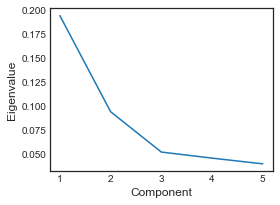

In [10]:
plt.figure(figsize=(4,3))
plt.plot(mca.eigenvalues_)
plt.xticks(ticks=np.arange(0,5,1),labels=np.arange(1,6,1))
plt.xlabel('Component',fontsize=12)
plt.ylabel('Eigenvalue',fontsize=12)
plt.show()

## Canonical correlation analysis (CCA)


In [11]:
y = behav_df[behaviour_list].values

if normalise_behav:
    y = st.vanderWaerden_transform(y)
    #y = zscore(y,axis=0)
    #y=quantile_transform(y,axis=0)
if reverse_behav:
    y = y*-1 
if regress_size:
    # find the size of each lesion
    s = np.sum(np.sum(np.sum(NIFTI,axis=0),axis=0),axis=0)
    
    # use regress to get the residual
    _betas,y = st.regression(y,s.reshape(len(s),-1))

# do cca
cca,p_adj = st.do_cca(mca.ind_scores,y,X,n_components=CCA_components,permutations=CCApermutations)
print('Raw LCr values=',np.round(cca.mode_r,2))
print('Padj for modes=',p_adj)

# put CCA weights back in original space
cca.x_weights_mat = np.zeros((n_nodes,n_nodes,CCA_components))
for i in range(CCA_components):
    data = np.zeros((len(keep_features)))
    data[keep_features] = cca.x_score_correlation[:,i]
    data_mat = np.zeros((n_nodes,n_nodes))
    data_mat[index_upper] = data
    cca.x_weights_mat[:,:,i] = data_mat
    
    # save cca out for graph and neurosynth analysis
    np.savetxt('cca_weights_mat_mode'+str(i)+'.csv',cca.x_weights_mat[:,:,i],delimiter=',')

100%|██████████| 1000/1000 [00:04<00:00, 201.41it/s]


Raw LCr values= [0.69 0.45 0.24 0.12 0.07]
Padj for modes= [0.0, 0.217, 0.998, 1.0, 1.0]


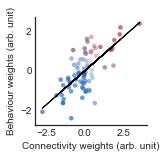

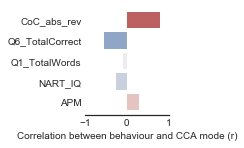

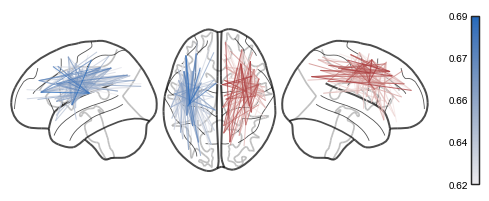

In [12]:
# cca plots (mode 1)
st.CCA_UV_plot(cca,title=outdir+'CCA_UV_mode1.svg')
st.CCA_behav_plot(cca,labels=behaviour_list,title=outdir+'CCA_beh_mode1.svg')

cm = cca.x_weights_mat[:,:,0] + cca.x_weights_mat[:,:,0].T
st.plot_connectome_threshold(cm,MNIcoords,num_edge=250,display_mode='lzr',edge_alpha=0.75,edge_lw=1,title=outdir+'CCA_brain_mode1')

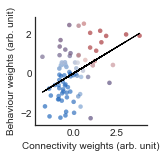

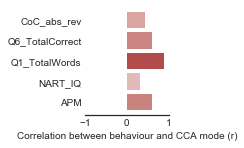

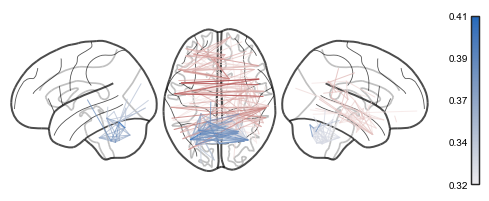

In [13]:
# cca plots (mode 1)
st.CCA_UV_plot(cca,title=outdir+'CCA_UV_mode2.svg',mode=1)
st.CCA_behav_plot(cca,labels=behaviour_list,title=outdir+'CCA_beh_mode2.svg',mode=1)

cm = cca.x_weights_mat[:,:,1] + cca.x_weights_mat[:,:,1].T
st.plot_connectome_threshold(cm,MNIcoords,num_edge=250,display_mode='lzr',edge_alpha=0.75,edge_lw=1,title=outdir+'CCA_brain_mode2.svg')


## Network affiliation analysis

In [14]:
import matplotlib.patches as patches
def network_plot(network_mean,network_labels,p_mat,mode=0,title=None,vmin=0,vmax=0.55):
    
    data = network_mean[:,:,mode]
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask,k=1)] = True
    plt.figure(figsize=(3.125,2.5))
    ax = sns.heatmap(abs(data),
                vmin=vmin,
                vmax=vmax,
                cmap='viridis',
                annot=False,
                fmt='.2f',
                mask=mask,
                linewidths=1,
                xticklabels=network_labels,
                yticklabels=network_labels)

    # draw significance
    for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if i > j:
                    continue
                if p_mat[i,j,mode]==True:
                    # Create a Rectangle patch
                    rect = patches.Rectangle((i,j),1,1,linewidth=1.5,edgecolor='r',facecolor='none')

                    # Add the patch to the Axes
                    ax.add_patch(rect)
     # draw signifcance legend
    rect = patches.Rectangle((4,1),1,1,linewidth=1.5,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
    if title is not None:
        plt.savefig(title,dpi=600)
    plt.show()

In [15]:
network_mean, p_fwe = st.net_affilation_wrapper(cca.x_weights_mat,CCA_components,networks,permutations=1000)


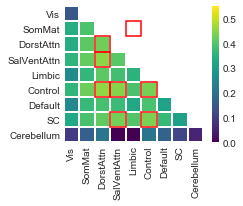

In [16]:
network_plot(network_mean,network_labels,p_fwe < 0.05,title=outdir+'CCA_mean_nets_mode1.svg')

In [17]:
# MNIcoords, networks, network_labels = st.get_atlas_info(parcellation=parcellation)
# network_mean = st.network_affilation_cm(cca,CCA_components,networks)
# st.network_plot(network_mean,network_labels,vmax=0.50,mode=0)

# Voxel based analyses
Uses a lot of memory! Runs out if voxel lesion inclusion is low when correlating with weights in the CCA...

## MCA

In [18]:
# which voxels to include when thresholding across participants
# ideally '0' but runs quite slow.
voxel_lesion_inclusion = 4

#check if MCA file already exists (very slow to ru)
file = '/Users/luke/Documents/Projects/StrokeNet/Data/MCA/voxel_MCA_results_thresh_'+str(voxel_lesion_inclusion)+'.pkl'
if os.path.isfile(file):
    print('Loading voxelwise MCA data...')
    mca = pickle.load(open(file,'rb'))
    print('Features included=',np.sum(mca.keep_features))

else:    
    # reshape connectivity data
    n_subs = np.shape(NIFTI)[3]
    n_voxels = np.int(np.shape(NIFTI)[0]*np.shape(NIFTI)[1]*np.shape(NIFTI)[2])
    print('Subjects=',n_subs,', voxels=',n_voxels)

    X_full = np.zeros((n_subs,n_voxels))
    for subj in range(n_subs):
        data = NIFTI[:,:,:,subj].copy()
        data = np.reshape(data,[n_voxels],order='C')
        X_full[subj,:] = data.copy()

    # binarize edges
    X_full = X_full > 0

    # remove non informative features
    keep_features = np.sum(X_full,axis=0)>voxel_lesion_inclusion
    X = X_full[:,keep_features]
    print('Features included=',np.sum(keep_features))
    print('Calculating MCA...')
    mca = st.do_MCA(X,n_components=MCA_components)
    print('Finished MCA!')

    # reshape data 
    dims = np.shape(NIFTI)
    mca.edge_scores_mat = np.zeros((dims[0],dims[1],dims[2],MCA_components))
    for i in range(MCA_components):
        data = np.zeros((len(keep_features)))
        data[keep_features] = mca.edge_scores[:,i]
        data_mat = np.zeros((dims[0],dims[1],dims[2]))
        data_mat = np.reshape(data,np.shape(data_mat),order='C')
        mca.edge_scores_mat[:,:,:,i] = data_mat
    print('Eigenvalues=',np.round(mca.eigenvalues_,4))
    print('Sum of eigenvalues=',np.round(np.sum(mca.eigenvalues_),4))

    # save data out
    mca.keep_features = keep_features.copy()
    mca.X = X
    pickle.dump(mca,open(file,'wb'))

Loading voxelwise MCA data...
Features included= 23390


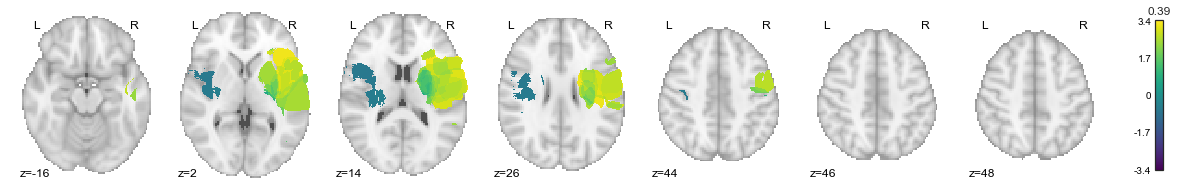

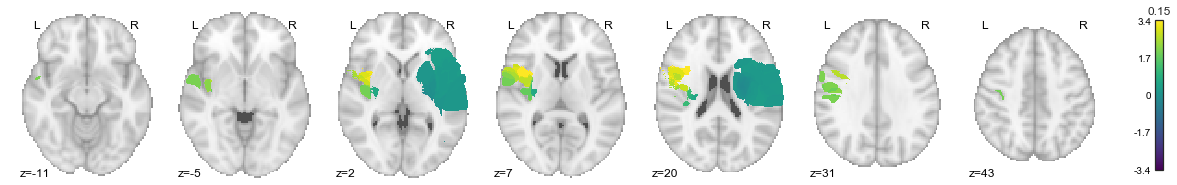

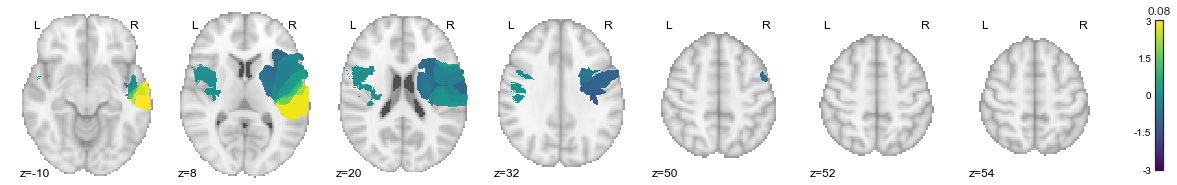

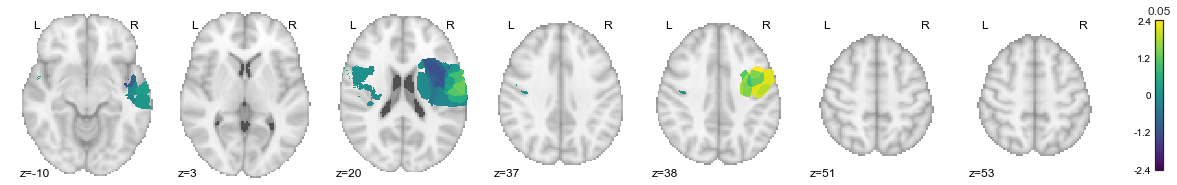

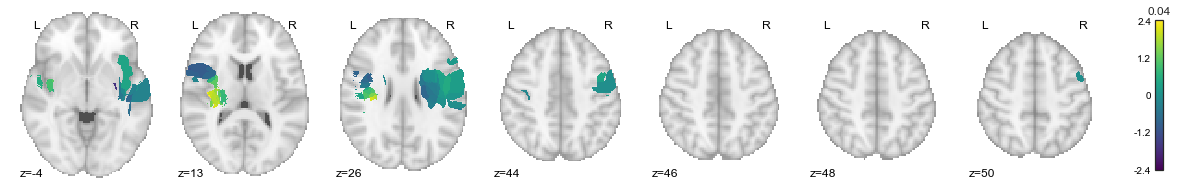

In [19]:
from nilearn import plotting
import nibabel as nib

affine = np.array([[  -1.,    0.,    0.,   90.],
       [   0.,    1.,    0., -126.],
       [   0.,    0.,    1.,  -72.],
       [   0.,    0.,    0.,    1.]])

for component in range(MCA_components):
    array_data = mca.edge_scores_mat[:,:,:,component]
    img = nib.Nifti1Image(array_data, affine)
    plotting.plot_stat_map(img,cmap='viridis',display_mode='z',colorbar=True)
    plt.title(np.round(mca.eigenvalues_[component],2))
    plt.show()

## CCA

In [ ]:
y = behav_df[behaviour_list].values

if normalise_behav:
    y = st.vanderWaerden_transform(y)
if reverse_behav:
    y = y*-1
    
# do cca
cca,p_adj = st.do_cca(mca.ind_scores,y,mca.X,n_components=CCA_components,permutations=CCApermutations)
print('Raw LCr values=',np.round(cca.mode_r,2))
print('Pvalues for components=',p_adj)

# reshape data 
dims = np.shape(NIFTI)
cca.x_weights_mat = np.zeros((dims[0],dims[1],dims[2],CCA_components))
for i in range(2):
    data = np.zeros((len(mca.keep_features)))
    data[mca.keep_features] = cca.x_score_correlation[:,i]
    data_mat = np.zeros((dims[0],dims[1],dims[2]))
    data_mat = np.reshape(data,np.shape(data_mat),order='C')
    cca.x_weights_mat[:,:,:,i] = data_mat

In [ ]:
# cca plots
st.CCA_UV_plot(cca)
st.CCA_behav_plot(cca,labels=behaviour_list)
st.CCA_nifti_brain_plot(cca)

In [ ]:
# cca plots
st.CCA_UV_plot(cca,mode=1)
st.CCA_behav_plot(cca,labels=behaviour_list,mode=1)
st.CCA_nifti_brain_plot(cca,mode=1)